In [1]:

# coding: utf-8

In [2]:


from __future__ import print_function

In [3]:


import argparse
import pickle
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import shutil

import time
import random
import torch.nn.functional as F

In [4]:


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
from pruned_layers import *
import numpy as np
from matplotlib import pyplot
from matplotlib.pylab import plt

from privacy_risk_score_utils import *

import urllib
import tarfile

In [5]:


use_cuda = torch.cuda.is_available()
use_cuda

True

In [6]:

DATASET_PATH = './datasets/texas/'

if not os.path.isdir(DATASET_PATH):
    mkdir_p(DATASET_PATH)


In [7]:
# # default way to load texas100 data
# DATASET_FEATURES = os.path.join(DATASET_PATH,'texas/100/feats')
# DATASET_LABELS = os.path.join(DATASET_PATH,'texas/100/labels')

# if not os.path.isfile(DATASET_FEATURES):
#     print("Dowloading the dataset...")
#     urllib.urlretrieve("https://www.comp.nus.edu.sg/~reza/files/dataset_texas.tgz",os.path.join(DATASET_PATH,'tmp.tgz'))
#     print('Dataset Downloaded')
#     tar = tarfile.open(os.path.join(DATASET_PATH,'tmp.tgz'))
#     tar.extractall(path=DATASET_PATH)
    
# X=[]
# Y=[]

# data_set_features =np.genfromtxt(DATASET_FEATURES,delimiter=',')
# data_set_label =np.genfromtxt(DATASET_LABELS,delimiter=',')

# X = data_set_features.astype(np.float64)
# Y = data_set_label.astype(np.int32)-1

# # # np.savez('texas100_data', x = X, y = Y)
# # # np.savez('texas100_index', x = init_r)

In [8]:
# You can save and load a npz file for faster loading
npzdata=np.load('./texas100_data.npz')
X=npzdata['x'][:,:]
Y=npzdata['y'][:]

In [9]:


# np.array_equal(X, X_x)

In [10]:


X.shape

(67330, 6169)

In [11]:


# # larger model
# class Texas(nn.Module):
#     def __init__(self,num_classes=100):
#         super(Texas, self).__init__()
#         self.features = nn.Sequential(
# #             nn.Linear(6169,1024),
#             PruneLinear(6169,2048),
#             nn.Tanh(),
#             PruneLinear(2048,1024),
#             nn.Tanh(),
#             PruneLinear(1024,512),
#             nn.Tanh(),
#             PruneLinear(512,256),
#             nn.Tanh(),
#             PruneLinear(256,128),
#             nn.Tanh(),
#         )
#         self.classifier = nn.Linear(128,num_classes)
# #         for key in self.state_dict():
# #             if key.split('.')[-1] == 'weight':    
# #                 nn.init.normal(self.state_dict()[key], std=0.01)
# #                 print (key)
                
# #             elif key.split('.')[-1] == 'bias':
# #                 self.state_dict()[key][...] = 0
        
#     def forward(self,x):
#         hidden_out = self.features(x)
        
#         return self.classifier(hidden_out),hidden_out

In [12]:


# larger model
class Texas_layer_out(nn.Module):
    def __init__(self,num_classes=100):
        super(Texas_layer_out, self).__init__()
#         self.features = nn.Sequential(
#             nn.Linear(6169,1024),
        self.fc1 = PruneLinear(6169,1024)
        self.tanh1 = nn.Tanh()
#         self.fc2 = PruneLinear(2048,1024)
#         self.tanh2 = nn.Tanh()
        self.fc3 = PruneLinear(1024,512)
        self.tanh3 = nn.Tanh()
        self.fc4 = PruneLinear(512,256)
        self.tanh4 = nn.Tanh()
        self.fc5 = PruneLinear(256,128)
        self.tanh5 = nn.Tanh()
#         )
        self.classifier = nn.Linear(128,num_classes)
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        y = self.fc1(x)
        y1 = self.tanh1(y)
#         y = self.fc2(y1)
#         y2 = self.tanh2(y)
        y = self.fc3(y1)
        y3 = self.tanh3(y)
        y = self.fc4(y3)
        y4 = self.tanh4(y)
        y = self.fc5(y4)
        y5 = self.tanh5(y)
        output = self.classifier(y5)
        
        return output, y1, y3, y4, y5

In [13]:


# larger model
class Texas_layer_out_scale(nn.Module):
    def __init__(self,num_classes=100, q = 100, alpha = 1):
        super(Texas_layer_out_scale, self).__init__()
#         self.features = nn.Sequential(
#             nn.Linear(6169,1024),
        self.fc1 = PruneLinear(6169,1024)
        self.tanh1 = nn.Tanh()
#         self.fc2 = PruneLinear(2048,1024)
#         self.tanh2 = nn.Tanh()
        self.fc3 = PruneLinear(1024,512)
        self.tanh3 = nn.Tanh()
        self.fc4 = PruneLinear(512,256)
        self.tanh4 = nn.Tanh()
        self.fc5 = PruneLinear(256,128)
        self.tanh5 = nn.Tanh()
#         )
        self.classifier = nn.Linear(128,num_classes)
    
        self.q = q
        self.alpha = alpha
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        y = self.fc1(x)
        y1 = self.tanh1(y)
        y1 = scale_by_percentage(y1, q=self.q, alpha = self.alpha)
#         y = self.fc2(y1)
#         y2 = self.tanh2(y)
        y = self.fc3(y1)
        y3 = self.tanh3(y)
        y3 = scale_by_percentage(y3, q=self.q, alpha = self.alpha)
        y = self.fc4(y3)
        y4 = self.tanh4(y)
        y4 = scale_by_percentage(y4, q=self.q, alpha = self.alpha)
        y = self.fc5(y4)
        y5 = self.tanh5(y)
        y5 = scale_by_percentage(y5, q=self.q, alpha = self.alpha)
        output = self.classifier(y5)
        
        return output, y1, y3, y4, y5

    
# def scale_by_percentage(x, q=5.0, alpha = 1):
#     """
#     scale paramters by threshold.

#     """
#     temp_shape = x.shape
#     weight = x.data.cpu().numpy()
#     flattened_weights = np.abs(weight.flatten())
#     nonzero = flattened_weights[np.nonzero(flattened_weights)]
#     percentile_value = np.percentile(nonzero, q)
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
#     new_mask = new_mask.reshape(temp_shape)
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
#     return x

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
#     flattened_weights = np.abs(weight)
#     percentile_value = np.percentile(flattened_weights, q)
    nonzero = flattened_weights[np.nonzero(flattened_weights)]
    percentile_value  = np.percentile(nonzero, q)
    amp = alpha - 1.
    
    tweight = x.data
    new_mask = (tweight >= percentile_value)*amp  + 1.
    
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)

##     new_mask = (flattened_weights >= percentile_value)*amp + 1.

#     new_mask = new_mask.reshape(temp_shape)
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
    x.data  = new_mask * tweight
    return x

In [14]:


# larger model
class Texas_layer_out_scale2(nn.Module):
    def __init__(self,num_classes=100, q = 100, alpha = 1):
        super(Texas_layer_out_scale2, self).__init__()
#         self.features = nn.Sequential(
#             nn.Linear(6169,1024),
        self.fc1 = PruneLinear(6169,1024)
        self.tanh1 = nn.Tanh()
#         self.fc2 = PruneLinear(2048,1024)
#         self.tanh2 = nn.Tanh()
        self.fc3 = PruneLinear(1024,512)
        self.tanh3 = nn.Tanh()
        self.fc4 = PruneLinear(512,256)
        self.tanh4 = nn.Tanh()
        self.fc5 = PruneLinear(256,128)
        self.tanh5 = nn.Tanh()
#         )
        self.classifier = nn.Linear(128,num_classes)
    
        self.q = q
        self.alpha = alpha
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        y = self.fc1(x)
        y1 = self.tanh1(y)
#         y1 = scale_by_percentage(y1, q=self.q, alpha = self.alpha)
#         y = self.fc2(y1)
#         y2 = self.tanh2(y)
        y = self.fc3(y1)
        y3 = self.tanh3(y)
#         y3 = scale_by_percentage(y3, q=self.q, alpha = self.alpha)
        y = self.fc4(y3)
        y4 = self.tanh4(y)
        y4 = scale_by_percentage(y4, q=self.q, alpha = self.alpha)
        y = self.fc5(y4)
        y5 = self.tanh5(y)
        y5 = scale_by_percentage(y5, q=self.q, alpha = self.alpha)
        output = self.classifier(y5)
        
        return output, y1, y3, y4, y5

    
# def scale_by_percentage(x, q=5.0, alpha = 1):
#     """
#     scale paramters by threshold.

#     """
#     temp_shape = x.shape
#     weight = x.data.cpu().numpy()
#     flattened_weights = np.abs(weight.flatten())
#     nonzero = flattened_weights[np.nonzero(flattened_weights)]
#     percentile_value = np.percentile(nonzero, q)
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
#     new_mask = new_mask.reshape(temp_shape)
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
#     return x

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
#     flattened_weights = np.abs(weight)
#     percentile_value = np.percentile(flattened_weights, q)
    nonzero = flattened_weights[np.nonzero(flattened_weights)]
    percentile_value  = np.percentile(nonzero, q)
    amp = alpha - 1.
    
    tweight = x.data
    new_mask = (tweight >= percentile_value)*amp  + 1.
    
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)

##     new_mask = (flattened_weights >= percentile_value)*amp + 1.

#     new_mask = new_mask.reshape(temp_shape)
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
    x.data  = new_mask * tweight
    return x

In [15]:


# larger model
class Texas_layer_out_scale2_mid(nn.Module):
    def __init__(self,num_classes=100, qfc_l = 100,qfc_h = 100, afc_l = 1, afc_h = 1):
        super(Texas_layer_out_scale2_mid, self).__init__()
#         self.features = nn.Sequential(
#             nn.Linear(6169,1024),
        self.fc1 = PruneLinear(6169,1024)
        self.tanh1 = nn.Tanh()
#         self.fc2 = PruneLinear(2048,1024)
#         self.tanh2 = nn.Tanh()
        self.fc3 = PruneLinear(1024,512)
        self.tanh3 = nn.Tanh()
        self.fc4 = PruneLinear(512,256)
        self.tanh4 = nn.Tanh()
        self.fc5 = PruneLinear(256,128)
        self.tanh5 = nn.Tanh()
#         )
        self.classifier = nn.Linear(128,num_classes)
    

        self.qfc_l = qfc_l
        self.qfc_h = qfc_h
        
        self.afc_l = afc_l
        self.afc_h= afc_h
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        y = self.fc1(x)
        y1 = self.tanh1(y)
#         y1 = scale_by_percentage(y1, q=self.q, alpha = self.alpha)
#         y = self.fc2(y1)
#         y2 = self.tanh2(y)
        y = self.fc3(y1)
        y3 = self.tanh3(y)
#         y3 = scale_by_percentage(y3, q=self.q, alpha = self.alpha)
        y = self.fc4(y3)
        y4 = self.tanh4(y)
        y4 = scale_by_percentage_mid(y4, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        y = self.fc5(y4)
        y5 = self.tanh5(y)
        y5 = scale_by_percentage_mid(y5, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        output = self.classifier(y5)
        
        return output, y1, y3, y4, y5

    
def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    nonzero = flattened_weights[np.nonzero(flattened_weights)]
    percentile_value = np.percentile(nonzero, q)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
    new_mask = new_mask.reshape(temp_shape)
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

def scale_by_percentage_mid(x, q_l = 50, q_h = 90, alpha_l = 1, alpha_h = 1):
    """
    scale paramters by threshold.

    """
#     print('q_l: ', q_l, 'q_h: ', q_h)
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    
    flattened_weights = np.abs(weight.flatten())
    nonzero = flattened_weights[np.nonzero(flattened_weights)]
    p_value_low = np.percentile(nonzero, q_l)
    p_value_high = np.percentile(nonzero, q_h)
#     p_value_low = np.percentile(flattened_weights, q_l)
#     p_value_high = np.percentile(flattened_weights, q_h)
#     print('p_value_low: ', p_value_low, 'p_value_high: ',p_value_high)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= p_value_low, alpha_l, mask)
#     print(new_mask)
    new_mask = np.where(flattened_weights >= p_value_high, alpha_h, new_mask)
#     print(new_mask)
    new_mask = new_mask.reshape(temp_shape)
    
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

In [16]:


# small model
class Texas_1layer(nn.Module):
    def __init__(self,num_classes=100):
        super(Texas_1layer, self).__init__()
        self.features = nn.Sequential(
#             nn.Linear(6169,1024),
            PruneLinear(6169,256),
            nn.Tanh()
#             PruneLinear(1024,512),
#             nn.Tanh(),
#             PruneLinear(512,256),
#             nn.Tanh(),
#             PruneLinear(512,128),
#             nn.Tanh()
        )
#         self.classifier = nn.Linear(128,num_classes)
        self.classifier = PruneLinear(256,num_classes)
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        hidden_out = self.features(x)
        
        return self.classifier(hidden_out),hidden_out

In [17]:


# small model
class Texas_2layer(nn.Module):
    def __init__(self,num_classes=100):
        super(Texas_2layer, self).__init__()
        self.features = nn.Sequential(
#             nn.Linear(6169,1024),
            PruneLinear(6169,512),
            nn.Tanh(),
#             PruneLinear(1024,512),
#             nn.Tanh(),
#             PruneLinear(512,256),
#             nn.Tanh(),
            PruneLinear(512,128),
            nn.Tanh()
        )
#         self.classifier = nn.Linear(128,num_classes)
        self.classifier = PruneLinear(128,num_classes)
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        hidden_out = self.features(x)
        
        return self.classifier(hidden_out),hidden_out

In [18]:


# small model
class Texas(nn.Module):
    def __init__(self,num_classes=100):
        super(Texas, self).__init__()
        self.features = nn.Sequential(
#             nn.Linear(6169,1024),
            PruneLinear(6169,512),
            nn.Tanh(),
            PruneLinear(1024,512),
            nn.Tanh(),
            PruneLinear(512,256),
            nn.Tanh(),
            PruneLinear(256,128),
            nn.Tanh()
        )
#         self.classifier = nn.Linear(128,num_classes)
        self.classifier = PruneLinear(128,num_classes)
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        hidden_out = self.features(x)
        
        return self.classifier(hidden_out),hidden_out

In [19]:


# small model
class Texas_drop(nn.Module):
    def __init__(self,p=0.5,num_classes = 100):
        self.num_classes = num_classes
        self.p = p
        super(Texas_drop, self).__init__()
        self.features = nn.Sequential(
#             nn.Linear(6169,1024),
            PruneLinear(6169,1024),
            nn.Tanh(),
            nn.Dropout2d(p),
            PruneLinear(1024,512),
            nn.Tanh(),
            nn.Dropout2d(p),
            PruneLinear(512,256),
            nn.Tanh(),
            nn.Dropout2d(p),
            PruneLinear(256,128),
            nn.Tanh(),
            nn.Dropout2d(p)
        )
#         self.classifier = nn.Linear(128,num_classes)
        self.classifier = PruneLinear(128,num_classes)
#         for key in self.state_dict():
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
        
    def forward(self,x):
        hidden_out = self.features(x)
        
        return self.classifier(hidden_out),hidden_out

In [20]:


# class InferenceAttack_HZ(nn.Module):
#     def __init__(self,num_classes):
#         self.num_classes=num_classes
#         super(InferenceAttack_HZ, self).__init__()
#         self.features=nn.Sequential(
#             nn.Linear(num_classes,512),
#             nn.ReLU(),
#             nn.Linear(512,64),
#             nn.ReLU(),
#             )
        
  
        
#         self.labels=nn.Sequential(
#            nn.Linear(num_classes,64),
#             )
#         self.combine=nn.Sequential(
#             nn.Linear(64*2,64),
#             nn.ReLU(),
#             nn.Linear(64,1),
#             )
#         for key in self.state_dict():
#             print (key)
#             if key.split('.')[-1] == 'weight':    
#                 nn.init.normal(self.state_dict()[key], std=0.01)
#                 print (key)
                
#             elif key.split('.')[-1] == 'bias':
#                 self.state_dict()[key][...] = 0
#         self.output= nn.Sigmoid()
#     def forward(self,x1,x2,l):
#         #print (l.size(),x.size())
#         out_x1 = self.features(x1)
        
#         out_l = self.labels(l)
        
        
        
            
#         is_member =self.combine( torch.cat((out_x1,out_l),1))
        
        
#         return self.output(is_member)

In [21]:


# defense model
class Defense_Model(nn.Module):
    def __init__(self,num_classes=1):
        super(Defense_Model, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(num_classes,256),
            
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
            )
        
        self.output= nn.Sigmoid()
    def forward(self,x):
        is_member = self.features(x)
        
        return self.output(is_member), is_member

In [22]:


class InferenceAttack_HZ(nn.Module):
    def __init__(self,num_classes):
        self.num_classes=num_classes
        super(InferenceAttack_HZ, self).__init__()
        self.features=nn.Sequential(
            nn.Linear(num_classes,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            )
        
  
        
        self.labels=nn.Sequential(
           nn.Linear(num_classes,512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            )
        self.combine=nn.Sequential(
            nn.Linear(64*2,512),
            
            nn.ReLU(),
            nn.Linear(512,256),
            
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
            )
        for key in self.state_dict():
            print (key)
            if key.split('.')[-1] == 'weight':    
                nn.init.normal(self.state_dict()[key], std=0.01)
                print (key)
                
            elif key.split('.')[-1] == 'bias':
                self.state_dict()[key][...] = 0
        self.output= nn.Sigmoid()
    def forward(self,x1,x2,l):
        #print (l.size(),x.size())
        out_x1 = self.features(x1)
        
        out_l = self.labels(l)

            
        is_member =self.combine( torch.cat((out_x1,out_l),1))
        
        return self.output(is_member), is_member
#         return self.output(is_member)
    


In [23]:

# r = np.arange(len_train)
# np.random.shuffle(r)
# pickle.dump(r,open('./random_r_texas100','w'))
# init_r=pickle.load(open('./random_r_texas100_prune')) #for py2
init_r=pickle.load(open('./random_r_texas100_prune', 'rb'), encoding='latin1')# for py3
X=X[init_r]
Y=Y[init_r]

float(X.shape[0])
len_train =len(X)

In [24]:


train_classifier_ratio, train_attack_ratio = float(10000)/float(X.shape[0]),0.3
train_classifier_data = X[:int(train_classifier_ratio*len_train)]
train_attack_data = X[int(train_classifier_ratio*len_train):int((train_classifier_ratio+train_attack_ratio)*len_train)]
test_data = X[int((train_classifier_ratio+train_attack_ratio)*len_train):]

In [25]:


# train_classifier_data.shape
# train_attack_data.shape
# test_data.shape

In [26]:



# train_classifier_ratio, train_attack_ratio = float(10000)/float(X.shape[0]),0.3
# train_classifier_ratio = 0.4
# train_attack_ratio = 0.3
train_classifier_data_length  = 10000

train_classifier_data = X[:train_classifier_data_length]
train_attack_data = X[10000:20000]
test_data = X[20000:]
# attacker_train_member = X[30000:35000]
# attacker_train_nonmember = X[35000:40000]
# original_train_data = X[:int((train_classifier_ratio+train_attack_ratio)*len_train)]

In [27]:


# train_classifier_ratio, train_attack_ratio = float(10000)/float(X.shape[0]),0.3
# print('train_classifier_ratio: ', train_classifier_ratio)
# print('train_attack_ratio: ', train_attack_ratio)
# train_classifier_ratio*len_train
print('train_classifier_data: ', len(train_classifier_data))
print('train_attack_data: ', len(train_attack_data))
print('test_data: ', len(test_data))

train_classifier_data:  10000
train_attack_data:  10000
test_data:  47330


In [28]:


train_classifier_label = Y[:train_classifier_data_length]
train_attack_label = Y[10000:20000]
test_label = Y[20000:]
# attacker_train_member_label = Y[30000:35000]
# attacker_train_nonmember_label = Y[35000:40000]
# original_train_label = Y[:int((train_classifier_ratio+train_attack_ratio)*len_train)]

In [29]:


# print(init_r[0:200])

In [30]:


def train(train_data,labels, model, criterion, optimizer, epoch, use_cuda,num_batchs=999999):
    # switch to train mode
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    
    end = time.time()
    len_t =  (len(train_data)//batch_size)-1
    
    for ind in range(len_t):
        if ind > num_batchs:
            break
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs,_,_,_,_ = model(inputs)
        
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%10==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg)
        


In [31]:


def test(test_data,labels, model, criterion, epoch, use_cuda):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    len_t =  (len(test_data)//batch_size)
    
    for ind in range(len_t):
        # measure data loading time
        inputs = test_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
        outputs,_,_,_,_ = model(inputs)
        
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind % 100==0:
            
            print ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=ind + 1,
                        size=len(test_data),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        ))
    return (losses.avg, top1.avg)

In [32]:


def train_privatly(train_data,labels, model,inference_model, criterion, optimizer, epoch, use_cuda,num_batchs=10000,skip_batch=0,alpha=0.5):
    # switch to train mode
    model.train()
    inference_model.eval()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()
    
    
    len_t =  (len(train_data)//batch_size)-1
    
    for ind in range(skip_batch,len_t):
        
        if ind >= skip_batch+num_batchs:
            break
        
        # measure data loading time
        
        #print (ind)
        
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        
        
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs,h_layer = model(inputs)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((outputs.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, targets.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        
        
        inference_output = inference_model ( outputs,h_layer,infer_input_one_hot)
        #print (inference_output.mean())
        
        relu = nn.ReLU()
        loss = criterion(outputs, targets) + ((alpha)*(torch.mean((inference_output)) - 0.5))

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  (alpha, '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg)

In [33]:


def outputres(test_data,labels, model, criterion, epoch, use_cuda):
    

    # switch to evaluate mode
    model.eval()
    end = time.time()
    len_t =  (len(test_data)//batch_size)-1
    alloutputs = np.zeros((batch_size*(len_t),100))
    for ind in range(len_t):
        # measure data loading time
        inputs = test_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
        outputs,_ = model(inputs)
        
        alloutputs[ind*batch_size:(ind+1)*batch_size,:]=F.softmax(outputs,dim=1).data.cpu().numpy()
    return alloutputs

In [34]:


def save_checkpoint(state, is_best, checkpoint='./checkpoints_texas_10class_little_model_defense/', filename='checkpoint.pth.tar'):
    if not os.path.isdir(checkpoint):
        mkdir_p(checkpoint)
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_best.pth.tar'))

In [35]:


best_acc = 0.0
epochs=100

In [36]:


def train_attack(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda,num_batchs=100000,skip_batch=0):
    # switch to train mode
    model.eval()
    attack_model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    #print (skip_batch, len_t)
    
    for ind in range(skip_batch, len_t):
        
        if ind >= skip_batch+num_batchs:
            break
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
            
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)
        # compute output
        outputs, h_layer = model(inputs)
        outputs_non, h_layer_non = model(inputs_attack)
        
        classifier_input = torch.cat((inputs,inputs_attack))
        comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
        if use_cuda:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
        else:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        attack_input = comb_inputs #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
#         sf= nn.Softmax(dim=0)
        
#         att_inp=torch.stack([attack_input, infer_input_one_hot],1)
        
        
#         att_inp = att_inp.view([attack_input.size()[0],1,2,attack_input.size(1)])
        
        #attack_output = attack_model(att_inp).view([-1])
        attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        
#         classifier_targets = comb_targets.clone().view([-1]).type(torch.cuda.LongTensor)
        
        loss_attack = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss_attack.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        #print ( attack_output.data.cpu().numpy(),v_is_member_labels.data.cpu().numpy() ,attack_input.data.cpu().numpy())
        #raise
        
        
        
        # compute gradient and do SGD step
        attack_optimizer.zero_grad()
        loss_attack.backward()
        attack_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
    return (losses.avg, top1.avg)

In [37]:


def test_attack(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,h_layer = model(inputs)
        outputs_non,h_layer_non = model(inputs_attack)
        
        comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
        if use_cuda:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
        else:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        attack_input = comb_inputs #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
        #attack_output = attack_model(att_inp).view([-1])
        attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        
        
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        sum_correct += correct
        #raise
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
            
#         break
#     return (losses.avg, top1.avg)  #,prec1,attack_output,  v_is_member_labels)
        
    return (losses.avg, top1.avg, sum_correct)

    return 

In [38]:


def train_attack_softmax(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda,num_batchs=100000,skip_batch=0):
    # switch to train mode
    model.eval()
    attack_model.train()
    
    softmax = nn.Softmax()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    #print (skip_batch, len_t)
    
    for ind in range(skip_batch, len_t):
        
        if ind >= skip_batch+num_batchs:
            break
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
            
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)
        # compute output
        outputs,_,_,_, h_layer = model(inputs)
        outputs_non,_,_,_, h_layer_non = model(inputs_attack)
        
        classifier_input = torch.cat((inputs,inputs_attack))
        comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
        if use_cuda:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
        else:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        attack_input = softmax(comb_inputs) #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
#         sf= nn.Softmax(dim=0)
        
#         att_inp=torch.stack([attack_input, infer_input_one_hot],1)
        
        
#         att_inp = att_inp.view([attack_input.size()[0],1,2,attack_input.size(1)])
        
        #attack_output = attack_model(att_inp).view([-1])
#         attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
#         print(attack_input.shape, comb_inputs_h.shape, infer_input_one_hot.shape)
        attack_output, _ = attack_model(attack_input,comb_inputs_h,infer_input_one_hot)
        attack_output = attack_output.view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        
#         classifier_targets = comb_targets.clone().view([-1]).type(torch.cuda.LongTensor)
        
        loss_attack = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss_attack.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        #print ( attack_output.data.cpu().numpy(),v_is_member_labels.data.cpu().numpy() ,attack_input.data.cpu().numpy())
        #raise
        
        
        
        # compute gradient and do SGD step
        attack_optimizer.zero_grad()
        loss_attack.backward()
        attack_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
    return (losses.avg, top1.avg)

In [39]:


def test_attack_softmax(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    softmax = nn.Softmax()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,_,_,_,h_layer = model(inputs)
        outputs_non,_,_,_,h_layer_non = model(inputs_attack)
        
        comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
        if use_cuda:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
        else:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        attack_input = softmax(comb_inputs) #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
        #attack_output = attack_model(att_inp).view([-1])
        attack_output, _ = attack_model(attack_input,comb_inputs_h,infer_input_one_hot)
        attack_output = attack_output.view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        
        
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        sum_correct += correct
        #raise
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
            
#         break
#     return (losses.avg, top1.avg)  #,prec1,attack_output,  v_is_member_labels)
        
    return (losses.avg, top1.avg, sum_correct)

    return 

In [40]:


def test_attack_softmax_modify(train_data,labels, train_logits,attack_data,attack_label,test_logits, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    softmax = nn.Softmax()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        train_attack_logits = train_logits[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        test_attack_logits = test_logits[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
            train_attack_logits, test_attack_logits = train_attack_logits.cuda(), test_attack_logits.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)
        train_attack_logits , test_attack_logits = torch.autograd.Variable(train_attack_logits), torch.autograd.Variable(test_attack_logits)
        
        # compute output
        outputs,h_layer = model(inputs)
        outputs_non,h_layer_non = model(inputs_attack)
        
        comb_inputs_h = torch.cat((h_layer,h_layer_non))
        
        comb_inputs = torch.cat((train_attack_logits,test_attack_logits))
        
        if use_cuda:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
        else:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        attack_input = softmax(comb_inputs) #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        #attack_output = attack_model(att_inp).view([-1])
#         attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
        attack_output, _ = attack_model(attack_input,comb_inputs_h,infer_input_one_hot)
        attack_output = attack_output.view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((train_attack_logits.size()[0]+test_attack_logits.size()[0]))
        att_labels [:train_attack_logits.size()[0]] =1.0
        att_labels [train_attack_logits.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
    
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        sum_correct += correct
        #raise
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
            
#         break
#     return (losses.avg, top1.avg)  #,prec1,attack_output,  v_is_member_labels)
        
    return (losses.avg, top1.avg, sum_correct)

    return 

In [41]:


def attack_test_trainset(train_data,labels, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    
    end = time.time()
#     len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))-1
    len_t = len(train_data)//batch_size + 1
    
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
#         inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
#         targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
#         #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
#             inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
#         inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,h_layer = model(inputs)
#         outputs_non,h_layer_non = model(inputs_attack)
        
        comb_inputs_h = h_layer  #torch.cat((h_layer,h_layer_non))
        comb_inputs = outputs  #torch.cat((outputs,outputs_non))
        
        if use_cuda:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
            comb_targets= targets.view([-1,1]).type(torch.cuda.FloatTensor)
        else:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            comb_targets= targets.view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        attack_input = comb_inputs #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
#         target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        target_one_hot_tr = one_hot_tr.scatter_(1, targets.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
        #attack_output = attack_model(att_inp).view([-1])
        attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0])) #+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
#         att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        sum_correct += correct
#         print('prec1: ', prec1)
        #raise
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
#         break
            
    return (losses.avg, top1.avg, sum_correct)
        
    return

In [42]:


def attack_test_testset(attack_data,labels, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    end = time.time()
#     len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))-1
    len_t = len(attack_data)//batch_size + 1
    
    for ind in range(len_t):
        # measure data loading time
        inputs = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
#         inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
#         targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
#         #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
#             inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
#         inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,h_layer = model(inputs)
#         outputs_non,h_layer_non = model(inputs_attack)
        
        comb_inputs_h = h_layer  #torch.cat((h_layer,h_layer_non))
        comb_inputs = outputs  #torch.cat((outputs,outputs_non))
        
        if use_cuda:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
            comb_targets= targets.view([-1,1]).type(torch.cuda.FloatTensor)
        else:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            comb_targets= targets.view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        attack_input = comb_inputs #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
#         target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        target_one_hot_tr = one_hot_tr.scatter_(1, targets.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
        #attack_output = attack_model(att_inp).view([-1])
        attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0])) #+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =0.0
#         att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() > 0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
#         print('prec1: ', prec1)
        #raise
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() > 0.5),(v_is_member_labels.data.cpu().numpy() > 0.5)))
        sum_correct += correct
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
#         break
    return (losses.avg, top1.avg, sum_correct) #, loss, attack_input)
        
    return

In [43]:


def train_defense_softmax(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda,num_batchs=100000,skip_batch=0):
    # switch to train mode
    model.eval()
    attack_model.train()
    
    softmax = nn.Softmax()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    #print (skip_batch, len_t)
    
    for ind in range(skip_batch, len_t):
        
        if ind >= skip_batch+num_batchs:
            break
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
            
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)
        # compute output
        outputs, _,_,_, h_layer = model(inputs)
        outputs_non, _,_,_, h_layer_non = model(inputs_attack)
        
        classifier_input = torch.cat((inputs,inputs_attack))
#         comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
#         if use_cuda:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
#         else:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
#         print (comb_inputs.size(),comb_targets.size())
#         print('comb_inputs.shape:',comb_inputs.shape)
#         print('comb_inputs:', comb_inputs[0,:])
        sort_inputs, indices= torch.sort(comb_inputs)
#         print('sort_inputs.shape:',sort_inputs.shape)
#         print('sort_inputs:', sort_inputs[0,:])
#         print(torch.sort(comb_inputs[0,:]))
#         break
        attack_input = softmax(sort_inputs) #torch.cat((comb_inputs,comb_targets),1)
#         print('attack_input:', attack_input[0,:])
#         print('attack_input.shape:',attack_input.shape)
#         break
#         one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
#         target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
#         infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
#         sf= nn.Softmax(dim=0)
        
#         att_inp=torch.stack([attack_input, infer_input_one_hot],1)
        
        
#         att_inp = att_inp.view([attack_input.size()[0],1,2,attack_input.size(1)])
        
        #attack_output = attack_model(att_inp).view([-1])
#         attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
#         attack_output = attack_model(attack_input).view([-1])
        attack_output,_ = attack_model(attack_input)
        attack_output = attack_output.view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        
#         classifier_targets = comb_targets.clone().view([-1]).type(torch.cuda.LongTensor)
        
        loss_attack = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss_attack.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        #print ( attack_output.data.cpu().numpy(),v_is_member_labels.data.cpu().numpy() ,attack_input.data.cpu().numpy())
        #raise
        
        
        # compute gradient and do SGD step
        attack_optimizer.zero_grad()
        loss_attack.backward()
        attack_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
    return (losses.avg, top1.avg)

In [44]:


def test_defense_softmax(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    softmax = nn.Softmax()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
#     print(len_t)
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs, _,_,_,h_layer = model(inputs)
        outputs_non, _,_,_,h_layer_non = model(inputs_attack)
        
#         comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
#         if use_cuda:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
#         else:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        sort_inputs, indices= torch.sort(comb_inputs)
        attack_input = softmax(sort_inputs) #torch.cat((comb_inputs,comb_targets),1)
        
        
#         one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
#         target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
#         infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
        #attack_output = attack_model(att_inp).view([-1])
#         attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
#         attack_output = attack_model(attack_input).view([-1])
        attack_output,_ = attack_model(attack_input)
        attack_output = attack_output.view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)

        
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        sum_correct += correct
        #raise
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
            
#         break
#     return (losses.avg, top1.avg)  #,prec1,attack_output,  v_is_member_labels)
        
    return (losses.avg, top1.avg, sum_correct)

    return 

In [45]:


def test_defense_softmax_unsort(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    softmax = nn.Softmax()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
#     print(len_t)
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,h_layer = model(inputs)
        outputs_non,h_layer_non = model(inputs_attack)
        
#         comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
#         if use_cuda:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
#         else:
#             comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
#         ---------------sort-------------------------------
#         sort_inputs, indices= torch.sort(comb_inputs)
#         attack_input = softmax(sort_inputs) #torch.cat((comb_inputs,comb_targets),1)
#         ---------------sort-------------------------------
        attack_input = softmax(comb_inputs)
        
#         one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
#         target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
#         infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
         
        
        
        #attack_output = attack_model(att_inp).view([-1])
#         attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
#         attack_output = attack_model(attack_input).view([-1])
        attack_output,_ = attack_model(attack_input)
        attack_output = attack_output.view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)

        
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        sum_correct += correct
        #raise
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
            
#         break
#     return (losses.avg, top1.avg)  #,prec1,attack_output,  v_is_member_labels)
        
    return (losses.avg, top1.avg, sum_correct)

    return 

In [46]:


classes = 100

# Complement Entropy (CE)


class ComplementEntropy(nn.Module):

    def __init__(self):
        super(ComplementEntropy, self).__init__()

    # here we implemented step by step for corresponding to our formula
    # described in the paper
    def forward(self, yHat, y):
        self.batch_size = len(y)
        self.classes = classes
        yHat = F.softmax(yHat, dim=1)
        Yg = torch.gather(yHat, 1, torch.unsqueeze(y, 1))
        Yg_ = (1 - Yg) + 1e-7  # avoiding numerical issues (first)
        Px = yHat / Yg_.view(len(yHat), 1)
        Px_log = torch.log(Px + 1e-10)  # avoiding numerical issues (second)
        y_zerohot = torch.ones(self.batch_size, self.classes).scatter_(
            1, y.view(self.batch_size, 1).data.cpu(), 0)
        output = Px * Px_log * y_zerohot.cuda()
        loss = torch.sum(output)
        loss /= float(self.batch_size)
        loss /= float(self.classes)
        return loss

In [47]:


classes = 100

class GuidedComplementEntropy(nn.Module):

    def __init__(self, alpha):
        super(GuidedComplementEntropy, self).__init__()
        self.alpha = alpha

    # here we implemented step by step for corresponding to our formula
    # described in the paper
    def forward(self, yHat, y):
        self.batch_size = len(y)
        self.classes = classes
        yHat = F.softmax(yHat, dim=1)
        Yg = torch.gather(yHat, 1, torch.unsqueeze(y, 1))
        Yg_ = (1 - Yg) + 1e-7  # avoiding numerical issues (first)
        # avoiding numerical issues (second)
        guided_factor = (Yg + 1e-7) ** self.alpha
        Px = yHat / Yg_.view(len(yHat), 1)
        Px_log = torch.log(Px + 1e-10)  # avoiding numerical issues (third)
        y_zerohot = torch.ones(self.batch_size, self.classes).scatter_(
            1, y.view(self.batch_size, 1).data.cpu(), 0)
        output = Px * Px_log * y_zerohot.cuda()
        guided_output = guided_factor.squeeze() * torch.sum(output, dim=1)
        loss = torch.sum(guided_output)
        loss /= float(self.batch_size)
        loss /= math.log(float(self.classes))
        return loss

In [48]:


def train_attack_softmax_sort_mod(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda,num_batchs=100000,skip_batch=0):
    # switch to train mode
    model.eval()
    attack_model.train()
    
    softmax = nn.Softmax()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    #print (skip_batch, len_t)
    
    for ind in range(skip_batch, len_t):
        
        if ind >= skip_batch+num_batchs:
            break
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
            
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)
        # compute output
        outputs, h_layer = model(inputs)
        outputs_non, h_layer_non = model(inputs_attack)
        
        classifier_input = torch.cat((inputs,inputs_attack))
        comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
        if use_cuda:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
        else:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        
        sort_inputs, indices= torch.sort(comb_inputs)
        
        attack_input = softmax(sort_inputs) #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        for i in range(len(indices)):
            target_one_hot_tr[i] = target_one_hot_tr[i][indices[i]]
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        
#         sf= nn.Softmax(dim=0)
        
#         att_inp=torch.stack([attack_input, infer_input_one_hot],1)
        
        
#         att_inp = att_inp.view([attack_input.size()[0],1,2,attack_input.size(1)])
        
        #attack_output = attack_model(att_inp).view([-1])
#         attack_output = attack_model(attack_input,comb_inputs_h,infer_input_one_hot).view([-1])
        attack_output, _ = attack_model(attack_input,comb_inputs_h,infer_input_one_hot)
        attack_output = attack_output.view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        
#         classifier_targets = comb_targets.clone().view([-1]).type(torch.cuda.LongTensor)
        
        loss_attack = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss_attack.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        #print ( attack_output.data.cpu().numpy(),v_is_member_labels.data.cpu().numpy() ,attack_input.data.cpu().numpy())
        #raise
        
        
        
        # compute gradient and do SGD step
        attack_optimizer.zero_grad()
        loss_attack.backward()
        attack_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
    return (losses.avg, top1.avg)

In [49]:


def test_attack_softmax_sort_mod(train_data,labels,attack_data,attack_label, model,attack_model, criterion,attack_criterion, optimizer,attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()
    
    softmax = nn.Softmax()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    sum_correct = 0.0
    
    end = time.time()
    len_t =  min((len(attack_data)//batch_size) ,(len(train_data)//batch_size))+1
    
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        
        inputs_attack = attack_data[ind*batch_size:(ind+1)*batch_size]
        targets_attack = attack_label[ind*batch_size:(ind+1)*batch_size]
        #print ( len(targets_attack), len(targets))
        
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs_attack , targets_attack = inputs_attack.cuda(), targets_attack.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack , targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,h_layer = model(inputs)
        outputs_non,h_layer_non = model(inputs_attack)
        
        comb_inputs_h = torch.cat((h_layer,h_layer_non))
        comb_inputs = torch.cat((outputs,outputs_non))
        
        if use_cuda:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.cuda.FloatTensor)
        else:
            comb_targets= torch.cat((targets,targets_attack)).view([-1,1]).type(torch.FloatTensor)
            
        #print (comb_inputs.size(),comb_targets.size())
        sort_inputs, indices= torch.sort(comb_inputs)
        
        attack_input = softmax(sort_inputs) #torch.cat((comb_inputs,comb_targets),1)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((attack_input.size()[0],outputs.size(1))))).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, torch.cat((targets,targets_attack)).type(torch.cuda.LongTensor).view([-1,1]).data,1)
        
        for i in range(len(indices)):
            target_one_hot_tr[i] = target_one_hot_tr[i][indices[i]]
        
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        
        #attack_output = attack_model(att_inp).view([-1])
        attack_output, _ = attack_model(attack_input,comb_inputs_h,infer_input_one_hot)
        attack_output = attack_output.view([-1])
        #attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0]+inputs_attack.size()[0]))
        att_labels [:inputs.size()[0]] =1.0
        att_labels [inputs.size()[0]:] =0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels)
        
        
        
        loss = attack_criterion(attack_output, v_is_member_labels)
        

        # measure accuracy and record loss
        #prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))
        
        prec1=np.mean(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])
        
        correct = np.sum(np.equal((attack_output.data.cpu().numpy() >0.5),(v_is_member_labels.data.cpu().numpy()> 0.5)))
        sum_correct += correct
        #raise
        
        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
            
#         break
#     return (losses.avg, top1.avg)  #,prec1,attack_output,  v_is_member_labels)
        
    return (losses.avg, top1.avg, sum_correct)

    return 

In [50]:


def train_max_var(train_data,labels, model, criterion, optimizer, class_count, class_index, epoch, use_cuda,num_batchs=999999, alpha = 1.0):
    # switch to train mode
    model.train()
    softmax = nn.Softmax()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_var = AverageMeter()
    max_train_outputs = AverageMeter()
    min_train_outputs = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    print('alpha: ', alpha)
    end = time.time()
    # len_t =  (len(train_classifier_label_tensor)//batch_size)-1
    len_t = np.max(class_count)/10
    batch_index = np.copy(class_index)
    batch_data = torch.Tensor()
    batch_label = torch.LongTensor()
    for ind in range(len_t):
        if ind > num_batchs:
            break
    #     # measure data loading time
    #     inputs = train_classifier_data_tensor[ind*batch_size:(ind+1)*batch_size]
    #     targets = train_classifier_label_tensor[ind*batch_size:(ind+1)*batch_size]
        inputs = torch.Tensor()
        targets = torch.LongTensor()
        for i in range(class_num):
            if batch_index[i] + 10 > class_index[i+1]:
            #             batch_data = sort_train_classifier_data[batch_index[i]: class_index[i+1]]
                batch_index[i] = class_index[i]
                inputs = torch.cat((inputs, train_classifier_data_tensor[batch_index[i]: batch_index[i] + 10]), 0)
                targets = torch.cat((targets, train_classifier_label_tensor[batch_index[i]: batch_index[i] + 10]),0)
                batch_index[i] = batch_index[i] + 10

            else:
                inputs = torch.cat((inputs, train_classifier_data_tensor[batch_index[i]: batch_index[i] + 10]), 0)
                targets= torch.cat((targets, train_classifier_label_tensor[batch_index[i]: batch_index[i] + 10]),0)
                batch_index[i] = batch_index[i] + 10

        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs,_ = model(inputs)

        soft_outputs = softmax(outputs)
        max_outputs = torch.max(soft_outputs,1).values
        min_outputs = torch.min(max_outputs)
        
        var = []
        for i in range(class_num):
            mean_outputs = torch.mean(soft_outputs[i*10:(i+1)*10],0)
            var.append(torch.mean(torch.sum((soft_outputs[i*10:(i+1)*10] - mean_outputs).pow(2),1)))
        batch_var = torch.stack(var,0)
        loss_var = alpha*(-torch.mean(batch_var))
        loss = criterion(outputs, targets) + loss_var
        
#         loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        losses_var.update(loss_var.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])
        max_train_outputs.update(torch.mean(max_outputs), inputs.size()[0])
        min_train_outputs.update(min_outputs, inputs.size()[0])
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%20==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s| Loss: {loss:.4f} | Var: {loss_var:.4f} | Max: {tmax:.4f} | Min: {tmin:.4f}| top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_var=losses_var.avg,
                    tmax = max_train_outputs.avg,
                    tmin = min_train_outputs.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg,losses_var.avg, top1.avg)
        


In [51]:


def train_half_diff(train_data,labels, model, criterion, optimizer,alpha, epoch, use_cuda,num_batchs=999999):
    # switch to train mode
    model.train()
    print('alpha = ', alpha)
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    diffes = AverageMeter()
    
    end = time.time()
    len_t =  (len(train_data)//batch_size)-1
    
    for ind in range(len_t):
        if ind > num_batchs:
            break
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs, y1,y2,y3,y4,y5 = model(inputs)
        
        out_list = [y1,y2,y3,y4,y5, outputs]
#         out_list[0].shape
        sum_diff = torch.zeros(out_list[0].shape[0]).cuda()
        for out_layer in out_list:

            # hidden_outputs.shape
            hidden_map = torch.ones(out_layer.shape[1]).cuda()
            hidden_map[out_layer.shape[1]//2:] = -1
        #     torch.sum(hidden_map)
            hd_diff_map = out_layer * hidden_map
            # hd_diff_map.shape
            hd_diff = torch.sum(hd_diff_map, 1)
            var_hd = hd_diff ** 2 / hd_diff_map.shape[1]
            sum_diff += var_hd
        
        diff_var = sum_diff.mean() * alpha
        loss = criterion(outputs, targets) + diff_var

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        diffes.update(diff_var.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | | diff: {diff:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    diff=diffes.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg, diffes.avg)
        


In [52]:


def train_half_diff_2(train_data,labels, model, criterion, optimizer,alpha, epoch, use_cuda,num_batchs=999999):
    # switch to train mode
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    diffes = AverageMeter()
    
    end = time.time()
    len_t =  (len(train_data)//batch_size)-1
    
    for ind in range(len_t):
        if ind > num_batchs:
            break
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs, hidden_outputs = model(inputs)
        
        hidden_map = torch.ones(256).cuda()
        hidden_map[128:] = -1
        torch.sum(hidden_map)
        hd_diff_map = hidden_outputs * hidden_map
        # hd_diff_map.shape
        hd_diff = torch.mean(torch.sum(hd_diff_map, 1))** 2 / 256

        output_map = torch.ones(10).cuda()
        output_map[5:] = -1
        output_diff_map = outputs * output_map
        # hd_diff_map.shape
        output_diff = torch.mean(torch.sum(output_diff_map , 1)) ** 2 / 10
#         output_diff 

        diff_var = alpha * (hd_diff + output_diff) 
        
        loss = criterion(outputs, targets) + diff_var

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        diffes.update(diff_var.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | | diff: {diff:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    diff=diffes.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg, diffes.avg)
        


In [53]:


def train_half_diff_min_var(train_data,labels, model, criterion, optimizer,alpha, epoch, use_cuda, var_n,mean_class,beta):
    # switch to train mode
    model.train()
    softmax = nn.Softmax()
    
    losses_var = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    diffes = AverageMeter()
    max_train_outputs = AverageMeter()
    min_train_outputs = AverageMeter()
    
    end = time.time()
    len_t =  (len(train_data)//batch_size)-1
    
    for ind in range(len_t):
        # measure data loading time
        
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs, y1,y3,y4,y5 = model(inputs)
        
        out_list = [y1,y3,y4,y5, outputs]
#         out_list[0].shape
        sum_diff = torch.zeros(out_list[0].shape[0]).cuda()
        for out_layer in out_list:

            # hidden_outputs.shape
            hidden_map = torch.ones(out_layer.shape[1]).cuda()
            hidden_map[out_layer.shape[1]//2:] = -1
        #     torch.sum(hidden_map)
            hd_diff_map = out_layer * hidden_map
            # hd_diff_map.shape
            hd_diff = torch.sum(hd_diff_map, 1)
            var_hd = hd_diff ** 2 / hd_diff_map.shape[1]
            sum_diff += var_hd
        
        diff_var = sum_diff.mean() * alpha
        
        soft_outputs = softmax(outputs)
        max_outputs = torch.max(soft_outputs,1).values
        min_outputs = torch.min(max_outputs)
        
        
#         mean_outputs = torch.mean(soft_outputs,0)
#         var = -torch.mean(torch.sum((soft_outputs - mean_outputs).pow(2),1))

        for i in range(batch_size):
#         var_n[targets[i]] = var_n[targets[i]] + 1
            var_n[targets[i]] += 1
    #         mean_class[targets[i]] = mean_class[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + soft_outputs[i]/var_n[targets[i]]
            mean_class[targets[i]] = mean_class[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + soft_outputs[i].data.cpu().numpy()/var_n[targets[i]]
    #         mean_var[targets[i]] = mean_var[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + torch.sum((soft_outputs[i] - mean_class[targets[i]]).pow(2))/var_n[targets[i]]
    #         mean_var[targets[i]] = mean_var[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + torch.sum((soft_outputs[i] - torch.from_numpy(mean_class[targets[i]]).cuda()).pow(2))/var_n[targets[i]]

        temp_mean = torch.from_numpy(mean_class).cuda()
        mean_var = torch.sum((soft_outputs - temp_mean[targets]).pow(2),1)
    
        var = torch.mean(mean_var)*beta
        
        loss = criterion(outputs, targets) + diff_var + var

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        diffes.update(diff_var.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])
        losses_var.update(var.data, inputs.size()[0])
        max_train_outputs.update(torch.mean(max_outputs), inputs.size()[0])
        min_train_outputs.update(min_outputs, inputs.size()[0])     
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%10==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} |var: {loss_var:.4f}| diff: {diff:.4f}|Max: {tmax:.4f} | Min: {tmin:.4f}| top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=ind + 1,
                    size=len_t,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_var=losses_var.avg,
                    diff=diffes.avg,
                    tmax = max_train_outputs.avg,
                    tmin = min_train_outputs.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg, diffes.avg, losses_var.avg)
        


In [54]:
def _log_value(probs, small_value=1e-30):
    return -torch.log(torch.max(probs, torch.tensor(small_value).cuda()))

def _m_entr_comp(probs, true_labels):
    log_probs = _log_value(probs)
    reverse_probs = 1-probs
    log_reverse_probs = _log_value(reverse_probs)
#     modified_probs = np.copy(probs)
    modified_probs = probs.detach().clone()
    modified_probs[range(true_labels.size(0)), true_labels] = reverse_probs[range(true_labels.size(0)), true_labels]
    modified_log_probs = log_reverse_probs.detach().clone()
    modified_log_probs[range(true_labels.size(0)), true_labels] = log_probs[range(true_labels.size(0)), true_labels]
    return torch.sum(torch.mul(modified_probs, modified_log_probs),axis=1)

In [55]:


def train_half_diff_min_var_me(train_data,labels, model, criterion, optimizer,alpha, epoch, use_cuda, var_n,mean_class,beta, gamma):
    # switch to train mode
    model.train()
    softmax = nn.Softmax()
    
    losses_var = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    diffes = AverageMeter()
    max_train_outputs = AverageMeter()
    min_train_outputs = AverageMeter()
    me_vars = AverageMeter()
    end = time.time()
    len_t =  (len(train_data)//batch_size)-1
    
    for ind in range(len_t):
        # measure data loading time
        inputs = train_data[ind*batch_size:(ind+1)*batch_size]
        targets = labels[ind*batch_size:(ind+1)*batch_size]
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs, y1,y3,y4,y5 = model(inputs)
        
        out_list = [y1,y3,y4,y5, outputs]
#         out_list[0].shape
        sum_diff = torch.zeros(out_list[0].shape[0]).cuda()
        for out_layer in out_list:

            # hidden_outputs.shape
            hidden_map = torch.ones(out_layer.shape[1]).cuda()
            hidden_map[out_layer.shape[1]//2:] = -1
        #     torch.sum(hidden_map)
            hd_diff_map = out_layer * hidden_map
            # hd_diff_map.shape
            hd_diff = torch.sum(hd_diff_map, 1)
            var_hd = hd_diff ** 2 / hd_diff_map.shape[1]
            sum_diff += var_hd
        
        diff_var = sum_diff.mean() * alpha
        
        soft_outputs = softmax(outputs)
        max_outputs = torch.max(soft_outputs,1).values
        min_outputs = torch.min(max_outputs)
        
#         s_tr_m_entr = _m_entr_comp(soft_outputs.data.cpu().numpy(), targets.data.cpu().numpy())
        s_tr_m_entr = _m_entr_comp(soft_outputs, targets)
        me_var = -torch.var(s_tr_m_entr) * gamma
#         me_var = torch.tensor(me_var).cuda()

#         mean_outputs = torch.mean(soft_outputs,0)
#         var = -torch.mean(torch.sum((soft_outputs - mean_outputs).pow(2),1))

        for i in range(batch_size):
#         var_n[targets[i]] = var_n[targets[i]] + 1
            var_n[targets[i]] += 1
    #         mean_class[targets[i]] = mean_class[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + soft_outputs[i]/var_n[targets[i]]
            mean_class[targets[i]] = mean_class[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + soft_outputs[i].data.cpu().numpy()/var_n[targets[i]]
    #         mean_var[targets[i]] = mean_var[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + torch.sum((soft_outputs[i] - mean_class[targets[i]]).pow(2))/var_n[targets[i]]
    #         mean_var[targets[i]] = mean_var[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + torch.sum((soft_outputs[i] - torch.from_numpy(mean_class[targets[i]]).cuda()).pow(2))/var_n[targets[i]]

        temp_mean = torch.from_numpy(mean_class).cuda()
        mean_var = torch.sum((soft_outputs - temp_mean[targets]).pow(2),1)
    
        var = torch.mean(mean_var)*beta
        
        loss = criterion(outputs, targets) + diff_var + var +  me_var

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        diffes.update(diff_var.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])
        losses_var.update(var.data, inputs.size()[0])
        me_vars.update(me_var.data, inputs.size()[0])
        max_train_outputs.update(torch.mean(max_outputs), inputs.size()[0])
        min_train_outputs.update(min_outputs, inputs.size()[0])     
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind%100==0:
            print  ('({batch}/{size}) | Batch: {bt:.3f}s | | Loss: {loss:.4f} |var: {loss_var:.4f}| diff: {diff:.4f}|me_var: {me_vars:.4f}|Max: {tmax:.4f} | Min: {tmin:.4f}| top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=ind + 1,
                    size=len_t,
#                     data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_var=losses_var.avg,
                    diff=diffes.avg,
                    me_vars = me_vars.avg,
                    tmax = max_train_outputs.avg,
                    tmin = min_train_outputs.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg, diffes.avg, losses_var.avg)
        


In [56]:


print('train_classifier_data: ',len(train_classifier_data))

print('train_attack_data: ',len(train_attack_data))

print('test_data: ',len(test_data))

train_classifier_data:  10000
train_attack_data:  10000
test_data:  47330


In [57]:


small_train_classifier_data_length = 10000
small_train_classifier_data = X[:small_train_classifier_data_length]
small_train_classifier_label = Y[:small_train_classifier_data_length]

len(small_train_classifier_data)

10000

In [58]:
a = np.zeros(100)
for i in range(len(Y)):
    a[Y[i]] += 1

sort_a = np.sort(a)
class_index = np.argsort(a)
select_class = class_index[90:]
select_class

array([93, 21, 97, 47, 30, 94, 14, 65, 72, 98])

In [59]:


class10_index = []
for i in range(len(Y)):
    if Y[i] in select_class:
        class10_index.append(i)

class10_index = np.asarray(class10_index)
class10_index.shape

(23076,)

In [60]:


ori_class10_label = Y[class10_index]
print(ori_class10_label.shape)
class10_data = X[class10_index]
sort_select_class = np.sort(select_class).tolist()
sort_select_class

(23076,)


[14, 21, 30, 47, 65, 72, 93, 94, 97, 98]

In [61]:


class10_label = np.zeros(len(ori_class10_label), dtype=int)
for i in range(len(class10_label)):
    class10_label[i] = sort_select_class.index(ori_class10_label[i])

In [62]:


class10_train_classifier_data = class10_data[:7000]
class10_train_attack_data = class10_data[7000:14000]
class10_test_data = class10_data[14000:]

class10_train_classifier_label = class10_label[:7000]
class10_train_attack_label = class10_label[7000:14000]
class10_test_label = class10_label[14000:]

print('class10_train_classifier_data: ',len(class10_train_classifier_data))

print('class10_train_attack_data: ',len(class10_train_attack_data))

print('class10_test_data: ',len(class10_test_data))

class10_train_classifier_data:  7000
class10_train_attack_data:  7000
class10_test_data:  9076


In [63]:


# npdata = np.load('texas10_sort_data.npz')
# sort_class10_data = npdata['x'][:,:]
# sort_class10_label = npdata['y'][:]

In [64]:
class100_trainset_index = []
class100_balance_test_index = []
class100_testset_index = []
class100_count = np.zeros(100)
for i in range(len(Y)):
    if(class100_count[Y[i]]<100):
        class100_trainset_index.append(i)
        class100_count[Y[i]] += 1
    elif(100<= class100_count[Y[i]]<200):
        class100_balance_test_index.append(i)
        class100_testset_index.append(i)
        class100_count[Y[i]] += 1
    elif(200<= class100_count[Y[i]]):
        class100_testset_index.append(i)
        class100_count[Y[i]] += 1

In [65]:
class100_trainset_index = np.asarray(class100_trainset_index)
class100_balance_test_index  = np.asarray(class100_balance_test_index)
class100_testset_index = np.asarray(class100_testset_index)

print(class100_trainset_index.shape)
print(class100_balance_test_index.shape)
print(class100_testset_index.shape)

(10000,)
(10000,)
(57330,)


In [66]:
class100_trainset_data = X[class100_trainset_index]
class100_balance_test_data = X[class100_balance_test_index]
class100_testset_data = X[class100_testset_index]

class100_trainset_label = Y[class100_trainset_index]
class100_balance_test_label = Y[class100_balance_test_index]
class100_testset_label = Y[class100_testset_index]

In [67]:
class100_trainset_data.shape

(10000, 6169)

In [68]:


# start train
lr=0.001
epochs=20
# p = 0.7
state={}
state['lr']=lr
# net = Texas()
# net = Texas_drop(p=p)
# net = Texas_2layer()
# net = Texas_1layer(num_classes=10)
net = Texas_layer_out(num_classes=100)
net = torch.nn.DataParallel(net).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
batch_size=128

In [69]:


def adjust_learning_rate(optimizer, epoch):
    global state
    if epoch in [800, 1500]:
#     if epoch in [100, 90]:
        state['lr'] *= 10 
#         state['lr'] *= 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']
    if epoch in [810,400,80,150, 1500]:
#     if epoch in [100, 90]:
        state['lr'] *= 0.1 
#         state['lr'] *= 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']

In [ ]:
# code for training defensive NeuGuard model



batch_size=256
best_acc = 0.0
best_epoch = 0
epochs = 200
num_class = 100
mean_class = np.zeros((num_class,num_class))
var_n = np.zeros(num_class)
alpha = 500
beta = 3000
train_time_list = []
print('alpha = ', alpha, ' beta = ', beta)

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)
#     if epoch == 30:
#         alpha = 3000
#         print('alpha = ', alpha, ' beta = ', beta)
    r= np.arange(len(train_classifier_data))
    np.random.shuffle(r)
    s_train_classifier_data = train_classifier_data[r]
    s_train_classifier_label = train_classifier_label[r]
    
    train_classifier_data_tensor = torch.from_numpy(s_train_classifier_data).type(torch.FloatTensor)
    train_classifier_label_tensor = torch.from_numpy(s_train_classifier_label).type(torch.LongTensor)
    
    
    test_data_tensor = torch.from_numpy(test_data).type(torch.FloatTensor)
    test_label_tensor = torch.from_numpy(test_label).type(torch.LongTensor)
    
    print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, epochs, state['lr']))
    train_time = time.time()
    train_loss, train_acc, diff, var = train_half_diff_min_var(train_classifier_data_tensor,train_classifier_label_tensor, net, criterion, optimizer, alpha, epoch, use_cuda, var_n,mean_class,beta)
    train_time_list.append(time.time()-train_time)
    print ('train acc: %.4f, train loss: %.4f, train diff: %.4f, last var: %.4f'%(train_acc, train_loss, diff, var))
    test_loss, test_acc = test(test_data_tensor,test_label_tensor, net, criterion, epoch, use_cuda)
    #privacy_loss, privacy_acc = privacy_train(trainloader,testloader,model,inferenece_model,criterion_attack,optimizer_mem,epoch,use_cuda)
    
    # append logger file
    
    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    print ('test acc: %.4f, test loss: %.4f, best acc: %.4f'%(test_acc, test_loss, best_acc))
    
        # save model
    if is_best or epoch+1 == epochs:
        if best_acc > 50:
            best_epoch = epoch+1;
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': net.state_dict(),
                    'acc': test_acc,
                    'best_acc': best_acc,
                    'optimizer' : optimizer.state_dict(),
                }, is_best, filename='Texas_5layer_balance_output_partition_alpha500_min_var_beta3000_epoch_%d'%(epoch+1))

In [ ]:
# code for training non defensive model
# lr = 0.001
batch_size=256
best_acc = 0.0
best_epoch = 0
epochs = 100
for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)
    r= np.arange(len(train_classifier_data))
    np.random.shuffle(r)
    s_train_classifier_data = train_classifier_data[r]
    s_train_classifier_label = train_classifier_label[r]
    
    train_classifier_data_tensor = torch.from_numpy(s_train_classifier_data).type(torch.FloatTensor)
    train_classifier_label_tensor = torch.from_numpy(s_train_classifier_label).type(torch.LongTensor)
    
    
    test_data_tensor = torch.from_numpy(test_data).type(torch.FloatTensor)
    test_label_tensor = torch.from_numpy(test_label).type(torch.LongTensor)
    
    print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, epochs, state['lr']))
        
    train_loss, train_acc = train(train_classifier_data_tensor,train_classifier_label_tensor, net, criterion, optimizer, epoch, use_cuda)
    print ('train acc: %.4f, train loss: %.4f'%(train_acc, train_loss))
    test_loss, test_acc = test(test_data_tensor,test_label_tensor, net, criterion, epoch, use_cuda)
    #privacy_loss, privacy_acc = privacy_train(trainloader,testloader,model,inferenece_model,criterion_attack,optimizer_mem,epoch,use_cuda)
    
    # append logger file
    
    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    print ('test acc: %.4f, test loss: %.4f, best acc: %.4f'%(test_acc, test_loss, best_acc))
    
    # save model
    if is_best or epoch+1 == epochs:
        if best_acc > 40:
            best_epoch = epoch+1;
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': net.state_dict(),
                    'acc': test_acc,
                    'best_acc': best_acc,
                    'optimizer' : optimizer.state_dict(),
                }, False, filename='Texas100_5layer_No_defenss_epoch_%d'%(epoch+1))



In [ ]:


# train_classifier_data = X[:int(train_classifier_ratio*len_train)]
# train_attack_data = X[int(train_classifier_ratio*len_train):int((train_classifier_ratio+train_attack_ratio)*len_train)]
# test_data = X[int((train_classifier_ratio+train_attack_ratio)*len_train):]

# train_classifier_label = Y[:int(train_classifier_ratio*len_train)]
# train_attack_label = Y[int(train_classifier_ratio*len_train):int((train_classifier_ratio+train_attack_ratio)*len_train)]
# test_label = Y[int((train_classifier_ratio+train_attack_ratio)*len_train):]

In [71]:


len(train_attack_data)

r = np.arange(len(train_attack_data))
r1 = np.arange(len(train_classifier_data))
np.random.shuffle(r)
np.random.shuffle(r1)
r2 = r1[r]

print(len(r))
print(len(r1))
print(len(r2))

print(max(r2))

10000
10000
10000
9999


In [70]:
# load saved model

# test_data_c = X[int((train_classifier_ratio+train_attack_ratio)*len_train):]
# test_label_c = Y[int((train_classifier_ratio+train_attack_ratio)*len_train):]
# test_data_c = X[40000:60000]
# test_label_c = Y[40000:60000]
# test_data_c = class10_data[14000:]
# test_label_c = class10_label[14000:]
test_data_c = test_data
test_label_c = test_label
epoch=0
batch_size=128
# net = Texas()
# net = Texas_drop(p)
# net = Texas_2layer()
# net = Texas_1layer(10)
net = Texas_layer_out(100)
# net = Texas_layer_out_scale(100, q = 50, alpha = 20)
# net = Texas_layer_out_scale2(100, q = 50, alpha = 200)


net = torch.nn.DataParallel(net).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
print(len(test_data_c))

47330


In [71]:


resume='./checkpoints_texas/Texas_5layer_balance_output_partition_alpha100_min_var_beta3000_epoch_50'


checkpoint = os.path.dirname(resume)
checkpoint = torch.load(resume)
net.load_state_dict(checkpoint['state_dict'])
print('==> Resumed from checkpoint..')
epoch = 0

==> Resumed from checkpoint..


In [72]:



test_loss, final_test_acc = test(torch.from_numpy(test_data_c).type(torch.FloatTensor) ,torch.from_numpy(test_label_c).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=final_test_acc))

# trainset_loss, trainset_acc = test(torch.from_numpy(small_train_classifier_data).type(torch.FloatTensor) ,torch.from_numpy(small_train_classifier_label).type(torch.LongTensor), net, criterion, epoch, use_cuda)

trainset_loss, trainset_acc = test(torch.from_numpy(train_classifier_data).type(torch.FloatTensor) ,torch.from_numpy(train_classifier_label).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('trainset_loss: {trainset_loss: .4f}, trainset_acc: {trainset_acc: .4f}'.format(trainset_loss=trainset_loss, trainset_acc=trainset_acc))

/tmp/ipykernel_2259819/1958796632.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/47330) Data: 0.000s | Batch: 0.902s | Loss: 4.1361 | top1:  59.3750 | top5:  79.6875
(101/47330) Data: 0.000s | Batch: 0.010s | Loss: 4.1397 | top1:  55.5925 | top5:  82.4876
(201/47330) Data: 0.000s | Batch: 0.006s | Loss: 4.1393 | top1:  56.0090 | top5:  82.7736
(301/47330) Data: 0.000s | Batch: 0.004s | Loss: 4.1394 | top1:  55.9567 | top5:  82.8748
test_loss:  4.1397, test_acc:  55.8435
(1/10000) Data: 0.000s | Batch: 0.005s | Loss: 4.0594 | top1:  70.3125 | top5:  93.7500
trainset_loss:  4.0306, trainset_acc:  73.5877


In [73]:


print(train_classifier_data.shape)
print(test_data_c.shape)

(10000, 6169)
(47330, 6169)


In [74]:
# load membership inference attack


r= np.arange(len(train_classifier_data))
np.random.shuffle(r)

train_classifier_data_tr_attack = train_classifier_data[r[:int(0.5*len(r))]]
train_classifier_label_tr_attack = train_classifier_label[r[:int(0.5*len(r))]]

train_classifier_data_te_attack = train_classifier_data[r[int(0.5*len(r)):]]
train_classifier_label_te_attack = train_classifier_label[r[int(0.5*len(r)):]]

len(train_classifier_data_te_attack)

5000

In [75]:


attack_model = InferenceAttack_HZ(100)
attack_model = torch.nn.DataParallel(attack_model).cuda()
attack_criterion = nn.MSELoss()
attack_optimizer = optim.Adam(attack_model.parameters(),lr=0.0001)

features.0.weight
features.0.weight
features.0.bias
features.2.weight
features.2.weight
features.2.bias
features.4.weight
features.4.weight
features.4.bias
labels.0.weight
labels.0.weight
labels.0.bias
labels.2.weight
labels.2.weight
labels.2.bias
combine.0.weight
combine.0.weight
combine.0.bias
combine.2.weight
combine.2.weight
combine.2.bias
combine.4.weight
combine.4.weight
combine.4.bias
combine.6.weight
combine.6.weight
combine.6.bias
combine.8.weight
combine.8.weight
combine.8.bias


/tmp/ipykernel_2259819/1378309152.py:38: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.state_dict()[key], std=0.01)


In [76]:
resume_defense='./checkpoints_texas/Texas_softmax_NSH_attack_best'
print('==> Resuming from checkpoint..')
assert os.path.isfile(resume), 'Error: no checkpoint directory found!'
checkpoint_defense = os.path.dirname(resume_defense)
checkpoint_defense = torch.load(resume_defense)
attack_model.load_state_dict(checkpoint_defense['state_dict'])

==> Resuming from checkpoint..


<All keys matched successfully>

In [77]:
r= np.arange(len(train_classifier_data_te_attack))
np.random.shuffle(r)
train_classifier_data_te_attack = train_classifier_data_te_attack[r]
train_classifier_label_te_attack = train_classifier_label_te_attack[r]
test_data_attack = test_data[r]
test_label_attack = test_label[r]
train_classifier_data_te_attack_tensor = torch.from_numpy(train_classifier_data_te_attack).type(torch.FloatTensor)
train_classifier_label_te_attack_tensor = torch.from_numpy(train_classifier_label_te_attack).type(torch.LongTensor)
test_data_tensor = torch.from_numpy(test_data_attack).type(torch.FloatTensor)
test_label_tensor = torch.from_numpy(test_label_attack).type(torch.LongTensor)
test_loss, test_acc, sum_correct = test_attack_softmax(train_classifier_data_te_attack_tensor,train_classifier_label_te_attack_tensor
                                     ,test_data_tensor,test_label_tensor,net,attack_model,criterion,attack_criterion,optimizer,attack_optimizer,epoch,use_cuda)
print ('test acc', test_acc, 'test_loss: ',test_loss)

(1/40) Data: 0.000s | Batch: 0.008s | | Loss: 0.2480 | top1:  0.5742 
test acc 0.5149 test_loss:  tensor(0.2502, device='cuda:0')


/tmp/ipykernel_2259819/34233529.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attack_input = softmax(comb_inputs) #torch.cat((comb_inputs,comb_targets),1)


In [78]:



# train_attack_data = train_attack_data

# train_attack_label = train_attack_label

# test_data = test_data
# test_label = test_label

print('train_attack_data: ', len(train_attack_data), '  test_data: ',len(test_data))

train_attack_data:  10000   test_data:  47330


In [79]:


train_classifier_data_te_attack.shape

(5000, 6169)

In [80]:


test_loss, final_test_acc = test(torch.from_numpy(train_classifier_data_tr_attack).type(torch.FloatTensor) ,torch.from_numpy(train_classifier_label_tr_attack).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=final_test_acc))

test_loss, final_test_acc = test(torch.from_numpy(train_classifier_data_te_attack).type(torch.FloatTensor) ,torch.from_numpy(train_classifier_label_te_attack).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=final_test_acc))

test_loss, final_test_acc = test(torch.from_numpy(train_attack_data).type(torch.FloatTensor) ,torch.from_numpy(train_attack_label).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=final_test_acc))

test_loss, final_test_acc = test(torch.from_numpy(test_data).type(torch.FloatTensor) ,torch.from_numpy(test_label).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=final_test_acc))



/tmp/ipykernel_2259819/1958796632.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/5000) Data: 0.000s | Batch: 0.004s | Loss: 4.0410 | top1:  75.7812 | top5:  94.5312
test_loss:  4.0315, test_acc:  73.6378
(1/5000) Data: 0.000s | Batch: 0.002s | Loss: 4.0822 | top1:  68.7500 | top5:  92.9688
test_loss:  4.0298, test_acc:  73.5377
(1/10000) Data: 0.000s | Batch: 0.002s | Loss: 4.1383 | top1:  55.4688 | top5:  86.7188
test_loss:  4.1413, test_acc:  56.0897
(1/47330) Data: 0.000s | Batch: 0.001s | Loss: 4.1361 | top1:  59.3750 | top5:  79.6875
(101/47330) Data: 0.000s | Batch: 0.001s | Loss: 4.1397 | top1:  55.5925 | top5:  82.4876
(201/47330) Data: 0.000s | Batch: 0.001s | Loss: 4.1393 | top1:  56.0090 | top5:  82.7736
(301/47330) Data: 0.000s | Batch: 0.001s | Loss: 4.1394 | top1:  55.9567 | top5:  82.8748
test_loss:  4.1397, test_acc:  55.8435


In [ ]:
# code for training attack model

best_acc= 0.0
batch_size=128
epochs = 200
for epoch in range(0, epochs):
#     adjust_learning_rate_attack(attack_optimizer, epoch)
    
    r= np.arange(len(train_classifier_data_tr_attack))
    np.random.shuffle(r)
    r1= np.arange(len(train_attack_data))
    np.random.shuffle(r1)
    r2 = r1[r]

    train_classifier_data_tr_attack = train_classifier_data_tr_attack[r]
    train_classifier_label_tr_attack = train_classifier_label_tr_attack[r]

    tr_attack_data = train_attack_data[r2]
    tr_attack_label = train_attack_label[r2]


    r= np.arange(len(train_classifier_data_te_attack))
    np.random.shuffle(r)
#     r1= np.arange(len(test_data)*0.5)
#     np.random.shuffle(r1)


    train_classifier_data_te_attack = train_classifier_data_te_attack[r]
    train_classifier_label_te_attack = train_classifier_label_te_attack[r]

    test_data_attack = test_data[r]
    test_label_attack = test_label[r]
    
    train_classifier_data_tr_attack_tensor = torch.from_numpy(train_classifier_data_tr_attack).type(torch.FloatTensor)
    train_classifier_label_tr_attack_tensor = torch.from_numpy(train_classifier_label_tr_attack).type(torch.LongTensor)

    train_classifier_data_te_attack_tensor = torch.from_numpy(train_classifier_data_te_attack).type(torch.FloatTensor)
    train_classifier_label_te_attack_tensor = torch.from_numpy(train_classifier_label_te_attack).type(torch.LongTensor)


#     r= np.arange(len(train_attack_data))
#     np.random.shuffle(r)

#     train_attack_data = train_attack_data[r]
#     train_attack_label = train_attack_label[r]

    train_attack_data_tensor = torch.from_numpy(tr_attack_data).type(torch.FloatTensor)
    train_attack_label_tensor = torch.from_numpy(tr_attack_label).type(torch.LongTensor)

    test_data_tensor = torch.from_numpy(test_data_attack).type(torch.FloatTensor)
    test_label_tensor = torch.from_numpy(test_label_attack).type(torch.LongTensor)
    print('\nEpoch: [%d | %d] , lr : 0.0001'% (epoch + 1, epochs))


    train_loss, train_acc = train_attack_softmax(train_classifier_data_tr_attack_tensor,train_classifier_label_tr_attack_tensor
                                         ,train_attack_data_tensor,train_attack_label_tensor,net,attack_model,criterion,attack_criterion,optimizer,attack_optimizer,epoch,use_cuda)

    print ('train acc',train_acc)
    test_loss, test_acc, sum_correct = test_attack_softmax(train_classifier_data_te_attack_tensor,train_classifier_label_te_attack_tensor
                                         ,test_data_tensor,test_label_tensor,net,attack_model,criterion,attack_criterion,optimizer,attack_optimizer,epoch,use_cuda)

    is_best = test_acc>best_acc or (1-test_acc)>best_acc
    
    best_acc = max(test_acc, best_acc)
    best_acc = max((1-test_acc), best_acc)
    if is_best or epoch+1 == epochs:
        save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': attack_model.state_dict(),
                    'acc': test_acc,
                    'best_acc': best_acc,
                    'optimizer' : attack_optimizer.state_dict(),
                }, False, filename='Texas_softmax_NSH_attack_best')
    
    print ('test acc',test_acc,best_acc)

print('Best classification acc:%.4f'%(final_test_acc))
print('Best attack acc:%.4f'%(best_acc))

In [81]:
# load NN attack model
defense_model = Defense_Model(100)
defense_model = torch.nn.DataParallel(defense_model).cuda()
defense_criterion = nn.MSELoss()
# defense_criterion = nn.CrossEntropyLoss()
at_lr = 0.001
state={}
state['lr']=at_lr
defense_optimizer = optim.Adam(defense_model.parameters(),lr=at_lr)
defense_model

DataParallel(
  (module): Defense_Model(
    (features): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
    (output): Sigmoid()
  )
)

In [82]:

def adjust_learning_rate_attack(optimizer, epoch):
    global state
    if epoch in [40, 90]:
#     if (epoch+1)%100 == 0:
        state['lr'] *= 0.1 
#         state['lr'] *= 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']

In [83]:
resume_defense='./checkpoints_texas/Texas_softmax_sort_NN_best'
print('==> Resuming from checkpoint..')
assert os.path.isfile(resume), 'Error: no checkpoint directory found!'
checkpoint_defense = os.path.dirname(resume_defense)
checkpoint_defense = torch.load(resume_defense)
defense_model.load_state_dict(checkpoint_defense['state_dict'])

==> Resuming from checkpoint..


<All keys matched successfully>

In [84]:
r= np.arange(len(train_classifier_data_te_attack))
np.random.shuffle(r)
#     r1= np.arange(len(test_data)*0.5)
#     np.random.shuffle(r1)


train_classifier_data_te_attack = train_classifier_data_te_attack[r]
train_classifier_label_te_attack = train_classifier_label_te_attack[r]

test_data_attack = test_data[r]
test_label_attack = test_label[r]
train_classifier_data_te_attack_tensor = torch.from_numpy(train_classifier_data_te_attack).type(torch.FloatTensor)
train_classifier_label_te_attack_tensor = torch.from_numpy(train_classifier_label_te_attack).type(torch.LongTensor)

test_data_tensor = torch.from_numpy(test_data_attack).type(torch.FloatTensor)
test_label_tensor = torch.from_numpy(test_label_attack).type(torch.LongTensor)
test_loss, test_acc, sum_correct = test_defense_softmax(train_classifier_data_te_attack_tensor,train_classifier_label_te_attack_tensor
                                     ,test_data_tensor,test_label_tensor,net,defense_model,criterion,defense_criterion,optimizer,defense_optimizer,epoch,use_cuda)


print ('test acc', test_acc, 'test_loss: ',test_loss)

(1/40) Data: 0.000s | Batch: 0.004s | | Loss: 0.2498 | top1:  0.5469 
test acc 0.5555 test_loss:  tensor(0.2458, device='cuda:0')


/tmp/ipykernel_2259819/754577571.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attack_input = softmax(sort_inputs) #torch.cat((comb_inputs,comb_targets),1)


In [ ]:
# code for training attack model
# 

best_acc= 0.0
batch_size=128
epochs = 100
for epoch in range(0, epochs):
    adjust_learning_rate_attack(defense_optimizer, epoch)
    
    r= np.arange(len(train_classifier_data_tr_attack))
    np.random.shuffle(r)
    r1= np.arange(len(train_attack_data))
    np.random.shuffle(r1)
    r2 = r1[r]

    train_classifier_data_tr_attack = train_classifier_data_tr_attack[r]
    train_classifier_label_tr_attack = train_classifier_label_tr_attack[r]

    tr_attack_data = train_attack_data[r2]
    tr_attack_label = train_attack_label[r2]


    r= np.arange(len(train_classifier_data_te_attack))
    np.random.shuffle(r)
#     r1= np.arange(len(test_data)*0.5)
#     np.random.shuffle(r1)


    train_classifier_data_te_attack = train_classifier_data_te_attack[r]
    train_classifier_label_te_attack = train_classifier_label_te_attack[r]

    test_data_attack = test_data[r]
    test_label_attack = test_label[r]

    
    train_classifier_data_tr_attack_tensor = torch.from_numpy(train_classifier_data_tr_attack).type(torch.FloatTensor)
    train_classifier_label_tr_attack_tensor = torch.from_numpy(train_classifier_label_tr_attack).type(torch.LongTensor)

    train_classifier_data_te_attack_tensor = torch.from_numpy(train_classifier_data_te_attack).type(torch.FloatTensor)
    train_classifier_label_te_attack_tensor = torch.from_numpy(train_classifier_label_te_attack).type(torch.LongTensor)


#     r= np.arange(len(train_attack_data))
#     np.random.shuffle(r)

#     train_attack_data = train_attack_data[r]
#     train_attack_label = train_attack_label[r]

    train_attack_data_tensor = torch.from_numpy(tr_attack_data).type(torch.FloatTensor)
    train_attack_label_tensor = torch.from_numpy(tr_attack_label).type(torch.LongTensor)

    test_data_tensor = torch.from_numpy(test_data_attack).type(torch.FloatTensor)
    test_label_tensor = torch.from_numpy(test_label_attack).type(torch.LongTensor)
    print('\nEpoch: [%d | %d] , lr : %f'% (epoch + 1, epochs, state['lr']))


    train_loss, train_acc = train_defense_softmax(train_classifier_data_tr_attack_tensor,train_classifier_label_tr_attack_tensor
                                         ,train_attack_data_tensor,train_attack_label_tensor,net,defense_model,criterion,defense_criterion,optimizer,defense_optimizer,epoch,use_cuda)

    print ('train acc',train_acc)
    test_loss, test_acc, sum_correct = test_defense_softmax(train_classifier_data_te_attack_tensor,train_classifier_label_te_attack_tensor
                                         ,test_data_tensor,test_label_tensor,net,defense_model,criterion,defense_criterion,optimizer,defense_optimizer,epoch,use_cuda)

    is_best = test_acc>best_acc or (1-test_acc)>best_acc
    
    best_acc = max(test_acc, best_acc)
    best_acc = max((1-test_acc), best_acc)
    if is_best or epoch+1 == epochs:
        save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': defense_model.state_dict(),                                       
                    'acc': test_acc,
                    'best_acc': best_acc,
                    'optimizer' : defense_optimizer.state_dict(),
                }, False, filename='Texas_softmax_sort_NN_best')
    
    print ('test acc',test_acc,best_acc)

print('Best classification acc:%.4f'%(final_test_acc))
print('Best attack acc:%.4f'%(best_acc))



In [85]:
# load for metric base attack
# Here we load a model that uses balanced data to train and evaluated

net = Texas_layer_out(100)
net = torch.nn.DataParallel(net).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
resume='./checkpoints_texas/Texas_5layer_balance_output_partition_alpha200_min_var_beta2000_epoch_69'
# resume='./checkpoints_texas_100/Texas_5layer_balance_output_partition_alpha300_min_var_beta2000_epoch_69'
checkpoint = os.path.dirname(resume)
checkpoint = torch.load(resume)
net.load_state_dict(checkpoint['state_dict'])
print('==> Resumed from checkpoint..')
epoch = 0

==> Resumed from checkpoint..


In [86]:
train_classifier_data = class100_trainset_data
train_classifier_label = class100_trainset_label
test_data = class100_testset_data
test_label = class100_testset_label

In [87]:

test_loss, final_test_acc = test(torch.from_numpy(test_data).type(torch.FloatTensor) ,torch.from_numpy(test_label).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=final_test_acc))

test_loss, final_test_acc = test(torch.from_numpy(class100_balance_test_data).type(torch.FloatTensor) ,torch.from_numpy(class100_balance_test_label).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('class100_balance_test_loss: {test_loss: .4f}, class100_balance_test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=final_test_acc))

trainset_loss, trainset_acc = test(torch.from_numpy(train_classifier_data).type(torch.FloatTensor) ,torch.from_numpy(train_classifier_label).type(torch.LongTensor), net, criterion, epoch, use_cuda)

print ('trainset_loss: {trainset_loss: .4f}, trainset_acc: {trainset_acc: .4f}'.format(trainset_loss=trainset_loss, trainset_acc=trainset_acc))

/tmp/ipykernel_2259819/1958796632.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/57330) Data: 0.000s | Batch: 0.002s | Loss: 4.3234 | top1:  25.7812 | top5:  68.7500
(101/57330) Data: 0.000s | Batch: 0.001s | Loss: 4.2414 | top1:  44.6627 | top5:  77.4752
(201/57330) Data: 0.000s | Batch: 0.001s | Loss: 4.2339 | top1:  46.5019 | top5:  78.2844
(301/57330) Data: 0.000s | Batch: 0.001s | Loss: 4.2300 | top1:  47.2903 | top5:  78.8414
(401/57330) Data: 0.000s | Batch: 0.001s | Loss: 4.2268 | top1:  47.7381 | top5:  79.0835
test_loss:  4.2258, test_acc:  47.9114
(1/10000) Data: 0.000s | Batch: 0.002s | Loss: 4.3234 | top1:  25.7812 | top5:  68.7500
class100_balance_test_loss:  4.1938, class100_balance_test_acc:  53.7861
(1/10000) Data: 0.000s | Batch: 0.002s | Loss: 4.1721 | top1:  56.2500 | top5:  89.8438
trainset_loss:  4.1008, trainset_acc:  73.7580


In [88]:



def test_loader(testloader, model, criterion, epoch, use_cuda):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
        outputs, y1, y3, y4, y5 = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx % 20==0:
            
            print ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(testloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        ))
    return (losses.avg, top1.avg)

In [89]:


def testloader_by_class(testloader, model, criterion, epoch, use_cuda):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    class_count = np.zeros(100)
    class_correct = np.zeros(100)
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
        outputs, y1, y3, y4, y5 = model(inputs)
#         outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        correct = correct.data.cpu().numpy()
        targets = targets.data.cpu().numpy()
        for i in range(len(targets)):
            class_count[targets[i]] += 1
            class_correct[targets[i]] += correct[0,i]
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx % 20==0:
            
            print ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(testloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        ))
    return (losses.avg, top1.avg, class_count, class_correct)

In [90]:


class black_box_benchmarks(object):
    
    def __init__(self, shadow_train_performance, shadow_test_performance, 
                 target_train_performance, target_test_performance, num_classes):
        '''
        each input contains both model predictions (shape: num_data*num_classes) and ground-truth labels. 
        '''
        self.num_classes = num_classes
        
        self.s_tr_outputs, self.s_tr_labels = shadow_train_performance
        self.s_te_outputs, self.s_te_labels = shadow_test_performance
        self.t_tr_outputs, self.t_tr_labels = target_train_performance
        self.t_te_outputs, self.t_te_labels = target_test_performance
        
        self.s_tr_corr = (np.argmax(self.s_tr_outputs, axis=1)==self.s_tr_labels).astype(int)
        self.s_te_corr = (np.argmax(self.s_te_outputs, axis=1)==self.s_te_labels).astype(int)
        self.t_tr_corr = (np.argmax(self.t_tr_outputs, axis=1)==self.t_tr_labels).astype(int)
        self.t_te_corr = (np.argmax(self.t_te_outputs, axis=1)==self.t_te_labels).astype(int)
        
        self.s_tr_conf = np.array([self.s_tr_outputs[i, self.s_tr_labels[i]] for i in range(len(self.s_tr_labels))])
        self.s_te_conf = np.array([self.s_te_outputs[i, self.s_te_labels[i]] for i in range(len(self.s_te_labels))])
        self.t_tr_conf = np.array([self.t_tr_outputs[i, self.t_tr_labels[i]] for i in range(len(self.t_tr_labels))])
        self.t_te_conf = np.array([self.t_te_outputs[i, self.t_te_labels[i]] for i in range(len(self.t_te_labels))])
        
        self.s_tr_entr = self._entr_comp(self.s_tr_outputs)
        self.s_te_entr = self._entr_comp(self.s_te_outputs)
        self.t_tr_entr = self._entr_comp(self.t_tr_outputs)
        self.t_te_entr = self._entr_comp(self.t_te_outputs)
        
        self.s_tr_m_entr = self._m_entr_comp(self.s_tr_outputs, self.s_tr_labels)
        self.s_te_m_entr = self._m_entr_comp(self.s_te_outputs, self.s_te_labels)
        self.t_tr_m_entr = self._m_entr_comp(self.t_tr_outputs, self.t_tr_labels)
        self.t_te_m_entr = self._m_entr_comp(self.t_te_outputs, self.t_te_labels)
        
    
    def _log_value(self, probs, small_value=1e-30):
        return -np.log(np.maximum(probs, small_value))
    
    def _entr_comp(self, probs):
        return np.sum(np.multiply(probs, self._log_value(probs)),axis=1)
    
    def _m_entr_comp(self, probs, true_labels):
        log_probs = self._log_value(probs)
        reverse_probs = 1-probs
        log_reverse_probs = self._log_value(reverse_probs)
        modified_probs = np.copy(probs)
        modified_probs[range(true_labels.size), true_labels] = reverse_probs[range(true_labels.size), true_labels]
        modified_log_probs = np.copy(log_reverse_probs)
        modified_log_probs[range(true_labels.size), true_labels] = log_probs[range(true_labels.size), true_labels]
        return np.sum(np.multiply(modified_probs, modified_log_probs),axis=1)
    
    def _thre_setting(self, tr_values, te_values):
        value_list = np.concatenate((tr_values, te_values))
        thre, max_acc = 0, 0
        for value in value_list:
            tr_ratio = np.sum(tr_values>=value)/(len(tr_values)+0.0)
            te_ratio = np.sum(te_values<value)/(len(te_values)+0.0)
            acc = 0.5*(tr_ratio + te_ratio)
            if acc > max_acc:
                thre, max_acc = value, acc
        return thre
    
    def _mem_inf_via_corr(self):
        # perform membership inference attack based on whether the input is correctly classified or not
        t_tr_acc = np.sum(self.t_tr_corr)/(len(self.t_tr_corr)+0.0)
        t_te_acc = np.sum(self.t_te_corr)/(len(self.t_te_corr)+0.0)
        mem_inf_acc = 0.5*(t_tr_acc + 1 - t_te_acc)
        print('With train acc {acc2:.3f} and test acc {acc3:.3f}\nFor membership inference attack via correctness, the attack acc is {acc1:.3f} '.format(acc1=mem_inf_acc, acc2=t_tr_acc, acc3=t_te_acc) )
        return
    
    def _mem_inf_thre(self, v_name, s_tr_values, s_te_values, t_tr_values, t_te_values):
        # perform membership inference attack by thresholding feature values: the feature can be prediction confidence,
        # (negative) prediction entropy, and (negative) modified entropy
        t_tr_mem, t_te_non_mem = 0, 0
        for num in range(self.num_classes):
            thre = self._thre_setting(s_tr_values[self.s_tr_labels==num], s_te_values[self.s_te_labels==num])
            t_tr_mem += np.sum(t_tr_values[self.t_tr_labels==num]>=thre)
            t_te_non_mem += np.sum(t_te_values[self.t_te_labels==num]<thre)
        mem_inf_acc = 0.5*(t_tr_mem/(len(self.t_tr_labels)+0.0) + t_te_non_mem/(len(self.t_te_labels)+0.0))
        print('For membership inference attack via {n}, the attack acc is {acc:.3f}'.format(n=v_name,acc=mem_inf_acc))
        return
    

    
    def _mem_inf_benchmarks(self, all_methods=True, benchmark_methods=[]):
        if (all_methods) or ('correctness' in benchmark_methods):
            self._mem_inf_via_corr()
        if (all_methods) or ('confidence' in benchmark_methods):
            self._mem_inf_thre('confidence', self.s_tr_conf, self.s_te_conf, self.t_tr_conf, self.t_te_conf)
        if (all_methods) or ('entropy' in benchmark_methods):
            self._mem_inf_thre('entropy', -self.s_tr_entr, -self.s_te_entr, -self.t_tr_entr, -self.t_te_entr)
        if (all_methods) or ('modified entropy' in benchmark_methods):
            self._mem_inf_thre('modified entropy', -self.s_tr_m_entr, -self.s_te_m_entr, -self.t_tr_m_entr, -self.t_te_m_entr)

        return self

In [91]:


def tensor_data_create(features, labels):
    tensor_x = torch.stack([torch.FloatTensor(i) for i in features]) # transform to torch tensors
    tensor_y = torch.stack([torch.LongTensor([i]) for i in labels])[:,0]
    dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    return dataset


# train_datax = train_classifier_data
# test_datax = test_data

# train_labelx = train_classifier_label
# test_labelx = test_label

train_datax = class100_trainset_data
test_datax = class100_balance_test_data 

train_labelx = class100_trainset_label
test_labelx = class100_balance_test_label

print('train_classifier_data: ', len(train_labelx))
print('test_data: ', len(test_labelx))

np.random.seed(100)
train_len = train_datax.shape[0]
r = np.arange(train_len)
np.random.shuffle(r)
shadow_indices = r[:train_len//2]
target_indices = r[train_len//2:]

shadow_train_data, shadow_train_label = train_datax[shadow_indices], train_labelx[shadow_indices]
target_train_data, target_train_label = train_datax[target_indices], train_labelx[target_indices]

test_len = 1*train_len
r = np.arange(test_len)
np.random.shuffle(r)
shadow_indices = r[:test_len//2]
target_indices = r[test_len//2:]

shadow_test_data, shadow_test_label = test_datax[shadow_indices], test_labelx[shadow_indices]
target_test_data, target_test_label = test_datax[target_indices], test_labelx[target_indices]

print('shadow_train_data: ', len(shadow_train_data))
print('shadow_test_data: ', len(shadow_test_data))


shadow_train = tensor_data_create(shadow_train_data, shadow_train_label)
shadow_train_loader = torch.utils.data.DataLoader(shadow_train, batch_size=batch_size, shuffle=True, num_workers=1)

shadow_test = tensor_data_create(shadow_test_data, shadow_test_label)
shadow_test_loader = torch.utils.data.DataLoader(shadow_test, batch_size=batch_size, shuffle=True, num_workers=1)

target_train = tensor_data_create(target_train_data, target_train_label)
target_train_loader = torch.utils.data.DataLoader(target_train, batch_size=batch_size, shuffle=True, num_workers=1)

target_test = tensor_data_create(target_test_data, target_test_label)
target_test_loader = torch.utils.data.DataLoader(target_test, batch_size=batch_size, shuffle=True, num_workers=1)
print('Data loading finished')

train_classifier_data:  10000
test_data:  10000
shadow_train_data:  5000
shadow_test_data:  5000
Data loading finished


In [92]:

test_loss, final_test_acc = test_loader(shadow_train_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test_loader(shadow_test_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test_loader(target_train_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test_loader(target_test_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

(1/40) Data: 0.082s | Batch: 0.087s | Loss: 4.1026 | top1:  75.7812 | top5:  98.4375
(21/40) Data: 0.006s | Batch: 0.008s | Loss: 4.0973 | top1:  74.2560 | top5:  96.5774
Classification accuracy: 73.54


/tmp/ipykernel_2259819/3348369123.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/40) Data: 0.104s | Batch: 0.108s | Loss: 4.2227 | top1:  57.0312 | top5:  83.5938
(21/40) Data: 0.007s | Batch: 0.009s | Loss: 4.1968 | top1:  53.0878 | top5:  83.4821
Classification accuracy: 53.28
(1/40) Data: 0.113s | Batch: 0.117s | Loss: 4.0969 | top1:  72.6562 | top5:  97.6562
(21/40) Data: 0.008s | Batch: 0.009s | Loss: 4.0982 | top1:  74.7396 | top5:  96.3542
Classification accuracy: 74.02
(1/40) Data: 0.096s | Batch: 0.101s | Loss: 4.1963 | top1:  53.1250 | top5:  80.4688
(21/40) Data: 0.009s | Batch: 0.011s | Loss: 4.1859 | top1:  54.5387 | top5:  83.5938
Classification accuracy: 54.36


In [93]:


test_loss, final_test_acc, s_tr_class, s_tr_correct = testloader_by_class(shadow_train_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc, t_tr_class, t_tr_correct = testloader_by_class(target_train_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc, s_te_class, s_te_correct = testloader_by_class(shadow_test_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc, t_te_class, t_te_correct = testloader_by_class(target_test_loader, net, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

/tmp/ipykernel_2259819/445169162.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/40) Data: 0.093s | Batch: 0.102s | Loss: 4.0950 | top1:  71.8750 | top5:  97.6562
(21/40) Data: 0.006s | Batch: 0.008s | Loss: 4.1014 | top1:  74.4420 | top5:  96.7262
Classification accuracy: 73.54
(1/40) Data: 0.089s | Batch: 0.094s | Loss: 4.0461 | top1:  80.4688 | top5:  97.6562
(21/40) Data: 0.006s | Batch: 0.008s | Loss: 4.1004 | top1:  74.6652 | top5:  95.6473
Classification accuracy: 74.02
(1/40) Data: 0.100s | Batch: 0.105s | Loss: 4.2014 | top1:  57.8125 | top5:  78.9062
(21/40) Data: 0.006s | Batch: 0.007s | Loss: 4.1976 | top1:  53.9435 | top5:  82.9613
Classification accuracy: 53.28
(1/40) Data: 0.084s | Batch: 0.089s | Loss: 4.1719 | top1:  56.2500 | top5:  85.1562
(21/40) Data: 0.005s | Batch: 0.007s | Loss: 4.1845 | top1:  54.9851 | top5:  83.8542
Classification accuracy: 54.36


In [94]:

def softmax_by_row(logits, T = 1.0):
    mx = np.max(logits, axis=-1, keepdims=True)
    exp = np.exp((logits - mx)/T)
    denominator = np.sum(exp, axis=-1, keepdims=True)
    return exp/denominator



def _model_predictions(model, dataloader):
    return_outputs, return_labels = [], []

    for (inputs, labels) in dataloader:
        return_labels.append(labels.numpy())
        outputs, y1, y3, y4, y5 = model.forward(inputs.cuda()) 
        return_outputs.append( softmax_by_row(outputs.data.cpu().numpy()) )
    return_outputs = np.concatenate(return_outputs)
    return_labels = np.concatenate(return_labels)
    return (return_outputs, return_labels)

shadow_train_performance = _model_predictions(net, shadow_train_loader)
shadow_test_performance = _model_predictions(net, shadow_test_loader)

target_train_performance = _model_predictions(net, target_train_loader)
target_test_performance = _model_predictions(net, target_test_loader)

In [95]:

print('Perform membership inference attacks!!!')
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                     target_train_performance,target_test_performance,num_classes=100)
res = MIA._mem_inf_benchmarks()

Perform membership inference attacks!!!
With train acc 0.740 and test acc 0.544
For membership inference attack via correctness, the attack acc is 0.598 
For membership inference attack via confidence, the attack acc is 0.626
For membership inference attack via entropy, the attack acc is 0.544
For membership inference attack via modified entropy, the attack acc is 0.626


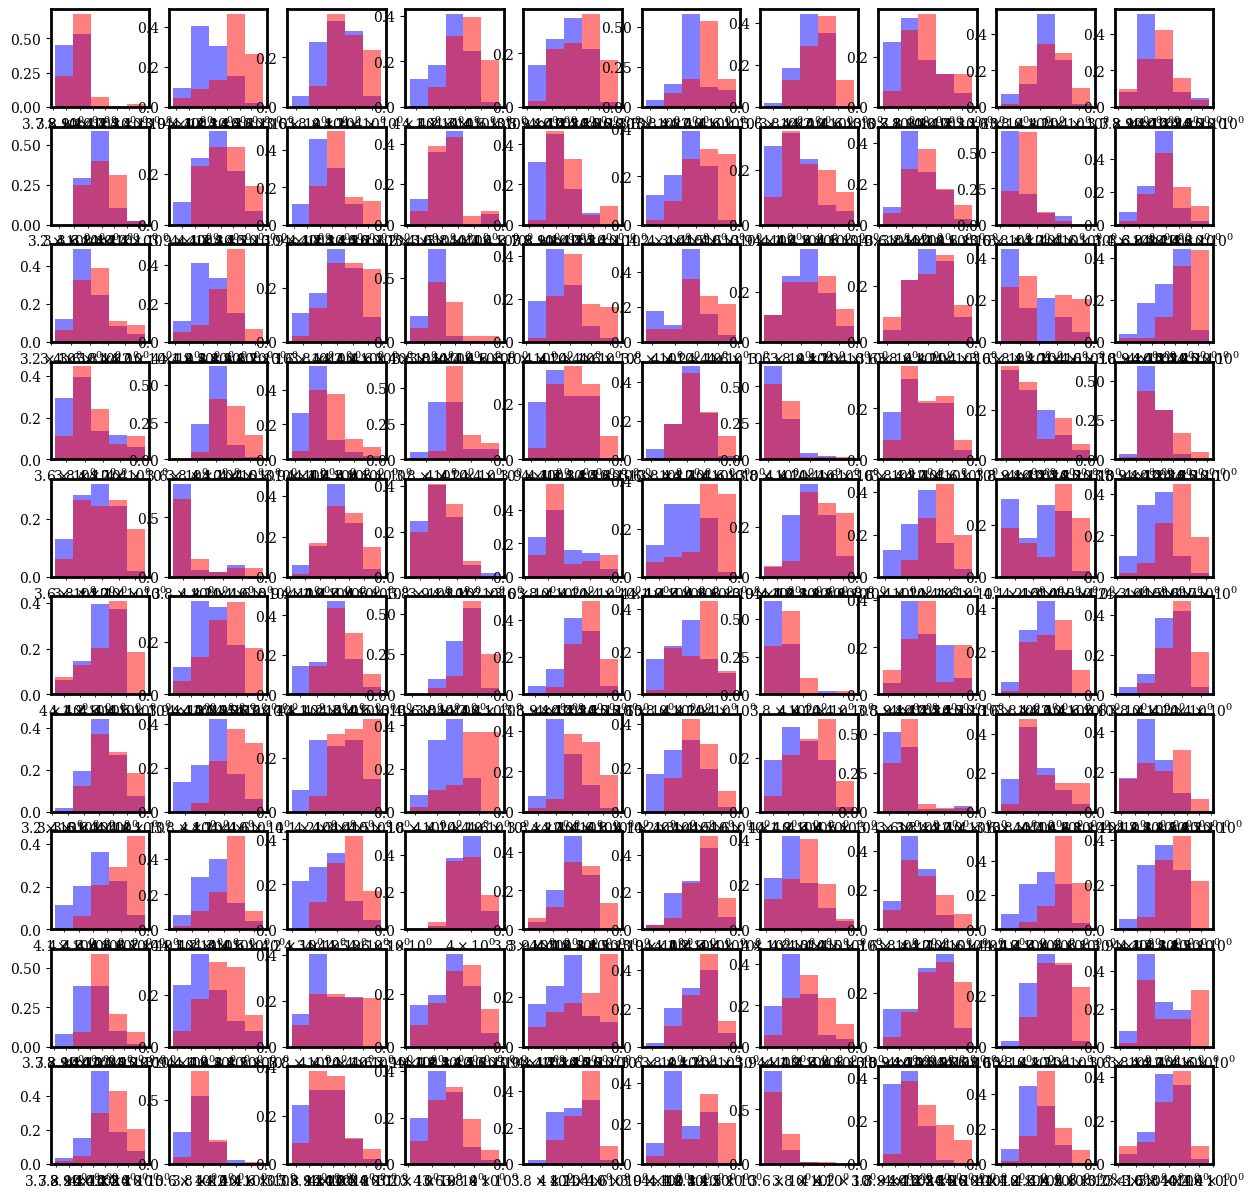

In [96]:


risk_score = calculate_risk_score(MIA.s_tr_m_entr, MIA.s_te_m_entr, MIA.s_tr_labels, MIA.s_te_labels, MIA.t_tr_m_entr, MIA.t_tr_labels)